In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import *
from validate import validate

In [2]:
station = 'muOsna'
dwd_specific_muOsna_skill = 0.39335437163541853

In [3]:
data_path = '/p/home/jusers/rojascampos1/juwels/MyProjects/PROJECT_deepacf/deeprain/rojascampos1/precipitation_prediction/data/'
trn_x = np.loadtxt(data_path + station + '_0_4_5x5_allFeatures_created_2020-10-23/train_x.csv', delimiter=',') #  np.loadtxt('data/' + station + '_0_4_5x5_allFeatures_created_2020-10-23/train_x.csv', delimiter=',')
trn_y = np.loadtxt(data_path + station + '_0_4_5x5_allFeatures_created_2020-10-23/train_y.csv', delimiter=',')
tst_x = np.loadtxt(data_path + station + '_0_4_5x5_allFeatures_created_2020-10-23/test_x.csv', delimiter=',')
tst_y = np.loadtxt(data_path + station + '_0_4_5x5_allFeatures_created_2020-10-23/test_y.csv', delimiter=',')

print(trn_x.shape, '--->', trn_y.shape)
print(tst_x.shape, '--->', tst_y.shape)

(737, 3575) ---> (737,)
(25, 3575) ---> (25,)


In [4]:
tst_t = np.load(data_path + station + '_0_4_5x5_allFeatures_created_2020-10-23/timepoints_test.npy')

tst_t.shape

(25,)

In [5]:
trn_y = np.exp(trn_y)
tst_y = np.exp(tst_y)
print(tst_y)

[0.1 0.2 0.4 0.4 0.2 0.1 0.1 2.  0.1 0.3 2.8 0.1 0.1 1.9 1.6 0.1 1.4 0.7
 0.6 0.1 0.3 0.1 0.6 0.1 1.1]


In [6]:
## Gordon's used features
id_predictors   = np.loadtxt('/p/project/deepacf/deeprain/rojascampos1/precipitation_prediction/data/00_gordons_regression'+'/'+station+'/'+station+ '_ID_Predictors.txt', dtype=np.int32,delimiter=',')
id_predictors   = id_predictors - 1 ## Matlab index start in 1
trn_x = trn_x[:, id_predictors]
tst_x = tst_x[:, id_predictors]

### Only days with rain

In [7]:
# trn_mask_rain = trn_y >= 0.1
# tst_mask_rain = tst_y >= 0.1

# trn_x = trn_x[trn_mask_rain]
# trn_y = trn_y[trn_mask_rain]
# tst_x = tst_x[tst_mask_rain]
# tst_y = tst_y[tst_mask_rain]
# tst_t = tst_t[tst_mask_rain]

# print(trn_x.shape, '--->', trn_y.shape)
# print(tst_x.shape, '--->', tst_y.shape)

In [8]:
batch_size = 8
epochs = 32

optimizer = tf.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredLogarithmicError()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)

cvalid_mses = []
cvalid_models = []


## In each run, train 10 differents model with cross validation
kf = KFold(n_splits=2, shuffle=True)
for train_index, test_index in kf.split(trn_x, trn_y):
    
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(trn_x.shape[1],)))
#     model.add(tf.keras.layers.Dense(10, activation='relu'))
#     model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer, loss)
    
    hist = model.fit(trn_x[train_index], trn_y[train_index], batch_size, epochs, validation_data=(trn_x[test_index], trn_y[test_index]), callbacks=[early_stop], shuffle=True)
    print(hist)
  
    preds = model(tst_x)
    preds = np.squeeze(preds)
    mse = mean_squared_error(tst_y, preds)
    cvalid_models.append(model)
    cvalid_mses.append(mse)
    print()
    print()
    
         

Epoch 1/32
46/46 [==============================] - 5s 111ms/step - loss: 0.1962 - val_loss: 0.1644
Epoch 2/32
46/46 [==============================] - 5s 111ms/step - loss: 0.1617 - val_loss: 0.1493
Epoch 3/32
46/46 [==============================] - 7s 143ms/step - loss: 0.1428 - val_loss: 0.1424
Epoch 4/32
46/46 [==============================] - 7s 148ms/step - loss: 0.1332 - val_loss: 0.1362
Epoch 5/32
46/46 [==============================] - 6s 137ms/step - loss: 0.1254 - val_loss: 0.1329
Epoch 6/32
46/46 [==============================] - 6s 137ms/step - loss: 0.1186 - val_loss: 0.1299
Epoch 7/32
46/46 [==============================] - 6s 138ms/step - loss: 0.1122 - val_loss: 0.1281
Epoch 8/32
46/46 [==============================] - 6s 132ms/step - loss: 0.1075 - val_loss: 0.1274
Epoch 9/32
46/46 [==============================] - 3s 67ms/step - loss: 0.1037 - val_loss: 0.1259
Epoch 10/32
46/46 [==============================] - 2s 53ms/step - loss: 0.1001 - val_loss: 0.1255
E

In [18]:
hist.history['val_loss'][-1]

0.13959264755249023

In [9]:
r = model.evaluate(tst_x)
print(r)

1/1 [==============================] - 0s 1ms/step - loss: 0.0000e+00
0.0


In [10]:
print(cvalid_mses)
index_best = np.argmin(cvalid_mses)
print('best=', index_best)

model = cvalid_models[index_best]
preds = model(tst_x)
preds = np.squeeze(preds)

[0.20066406717728502, 0.4498341678593778]
best= 0


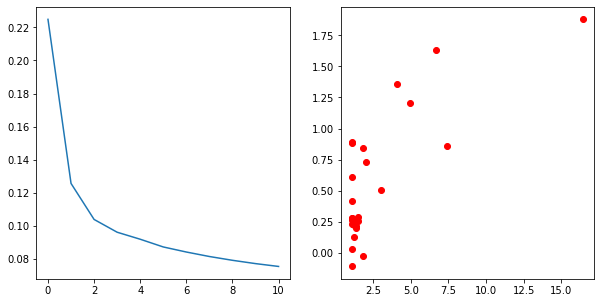

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(hist.history['loss'])
ax[1].plot(np.exp(tst_y), preds, 'ro')
fig.show()

In [12]:
preds

array([ 0.8942099 ,  0.22339682,  0.28670686,  0.25349954,  0.12857412,
        0.28329048,  0.61343586,  0.8601953 ,  0.28073144,  0.21251774,
        1.8792038 , -0.1109027 ,  0.02808332,  1.6353595 ,  1.2015617 ,
        0.26403046,  1.358063  ,  0.72777253, -0.02744341,  0.4168808 ,
        0.194997  ,  0.8846247 ,  0.83948344,  0.23357168,  0.5020814 ],
      dtype=float32)

In [13]:
leps_preds = validate(preds, tst_t, 0, 4, False, station)['LEPS']
leps_cosmo = validate(preds, tst_t, 0, 4, True, station)['LEPS'][9]
skill = 1 - (leps_preds / leps_cosmo)
print(skill)

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [int]

In [ ]:
print(skill > dwd_specific_muOsna_skill)